## Description :
- Graph for Code Generation with Tests to validate the code generated , and we will provide Docs to help the LLM using RAG technique.

In [3]:
# ANSI escape codes
RED = "\033[91m"
GREEN = "\033[92m"
YELLOW = "\033[93m"
BLUE = "\033[94m"
RESET = "\033[0m"

print(f"{RED}This is red text{RESET}")
print(f"{GREEN}This is green text{RESET}")
print(f"{YELLOW}This is yellow text{RESET}")
print(f"{BLUE}This is blue text{RESET}")


This is red text
This is green text
This is yellow text
This is blue text


## RAG Tool :

### Load Our Docs :

In [ ]:
from bs4 import BeautifulSoup as Soup
from langchain_community.document_loaders.recursive_url_loader import RecursiveUrlLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

# LCEL docs 
# WebScraping of the WebPage about langchain Expressions language to counstruct our Doc

url = "https://python.langchain.com/v0.2/docs/concepts/#langchain-expression-language-lcel"
loader = RecursiveUrlLoader(
    url=url, max_depth=20, extractor=lambda x: Soup(x, "html.parser").text
)
doc = loader.load()

# Sort the list based on the URLs and get the text
d_sorted = sorted(doc, key=lambda x: x.metadata["source"])
d_reversed = list(reversed(d_sorted))
concatenated_content = "\n\n\n --- \n\n\n".join(
    [doc.page_content for doc in d_reversed]
)
#print("🔋🔋🔋🔋🔋🔋🔋🔋🔋🔋🔋🔋🔋")
#print(doc[0].page_content)

### Chunking :

In [ ]:
########################################### Chunking
def split_documents(documents):
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=800,
        chunk_overlap=80,
        length_function=len,
        is_separator_regex=False,
    )
    return text_splitter.split_documents(documents)

chunks = split_documents(doc)

In [ ]:
chunks

### Embedding :

In [8]:
from langchain_community.embeddings.ollama import OllamaEmbeddings

def Embedding_function():
    embeddings = OllamaEmbeddings(model="nomic-embed-text:v1.5",show_progress =True)
    return embeddings

### Create Chroma DataBase:

In [ ]:
import os
import shutil
from langchain_community.vectorstores import Chroma

In [ ]:
CHROMA_PATH = "/teamspace/studios/this_studio/LLM_Courses/Pratiques/Langraph/Code Assistant/Chroma"

In [ ]:
def clear_database():
    if os.path.exists(CHROMA_PATH):
        shutil.rmtree(CHROMA_PATH)
        
def save_to_chroma(chunks,Ids): 
    clear_database()
    # Create a new DB from the chunks.
    db = Chroma.from_documents(chunks, Embedding_function(), persist_directory=CHROMA_PATH,ids=Ids)
    db.persist() # Forcing the Save
    print(f"Saved {len(chunks)} chunks to {CHROMA_PATH}.")


def Create_Chunks_Ids(chunks):
    current_chunk_index = 0
    ids = []
    for chunk in chunks:
        chunk.metadata["id"] = f"{current_chunk_index}"
        ids.append(f"{current_chunk_index}")
        current_chunk_index+=1
    return chunks,ids

In [ ]:
chunks,ids = Create_Chunks_Ids(chunks)
chunks[10]

In [ ]:
save_to_chroma(chunks,ids)

### Searching for relevent chunks:

In [ ]:
def Get_Context(Question):
    # Searching for Relevent Chunks from DataBase
    results = db.similarity_search_with_relevance_scores(Question,k=3)
    context_text = "\n\n---\n\n".join([chunk.page_content for chunk, _score in results])
    return context_text

In [ ]:
db = Chroma(persist_directory=CHROMA_PATH, embedding_function=Embedding_function())

In [ ]:
question = "How can I use a prompt and model to create a chain in LCEL that returns raw ChatMessages?"
context = Get_Context(question)
print(context)

## Initialize the Graph :

In [4]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages

In [5]:
class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

## RAG Node :

In [9]:
import os
import shutil
from langchain_community.vectorstores import Chroma

In [10]:
CHROMA_PATH = "/teamspace/studios/this_studio/LLM_Courses/Pratiques/Langraph/Code Assistant/Chroma"
db = Chroma(persist_directory=CHROMA_PATH, embedding_function=Embedding_function())

In [11]:
from langchain_core.tools import StructuredTool
from langchain.pydantic_v1 import BaseModel, Field

class RAG_Arg(BaseModel):
    query: str = Field(...,description="The query to use in searching for relevent information from  a the Database of information about LCEL")

def Get_Context(query:str)-> str:
    # Searching for Relevent Chunks from DataBase
    results = db.similarity_search_with_relevance_scores(query,k=3)
    context_text = "\n\n---\n\n".join([chunk.page_content for chunk, _score in results])
    return context_text

RAG_System = StructuredTool.from_function(
    func=Get_Context,
    name="RAG System",
    description="This tool give a good informations about Langchain Expressions Launguage from the Documentation of Langchain Faramwork",
    args_schema=RAG_Arg,
    return_direct=False,
)


In [12]:
from langchain_core.messages import ToolMessage

def Get_AIMessage(state:State):
    messages = state.get("messages", []) 
    # .get : Return the value associeted to the key "messages" if the key not exist it returns an empty list
    if messages:
        message = messages[-1]
        # message is the last in messages list.
    return message

def RAG_function(state:State,tool = RAG_System):
    message = Get_AIMessage(state)
        
    Tool_call = message.tool_calls[0]
    print("Tofv ndnfvn    ",Tool_call.keys())
    # Execute the Tool called by the LLM
    Tool_arguments = Tool_call["args"]
    Tool_Name = Tool_call["name"]
    print(f"⚙️{YELLOW} {Tool_Name} is Executing{RESET}")
    
    Tool_result = tool.invoke(Tool_arguments)
    Tool_Message =  ToolMessage(content=Tool_result,name=Tool_call["name"],tool_call_id=Tool_call["id"])
    
    return {"messages": Tool_Message}


## LLM Node :

In [13]:
from langchain_openai import ChatOpenAI

In [14]:
tools = [RAG_System]
llm = ChatOpenAI(api_key="ollama",model="llama3-groq-tool-use:8b",base_url="http://localhost:11434/v1")
llm_with_tools = llm.bind_tools(tools)

In [15]:
def LLM_function(state: State):
    #print("Sate :",state)
    #print(f"State Messages : ",state["messages"])
    print(f"{BLUE}State messages :{RESET}",state["messages"])
    print(f"💡{GREEN}LLM is Thinking !{RESET}")
    
    prompt = state["messages"] # List of Messages
    response = llm_with_tools.invoke(prompt)
    return {"messages": [response]}

## Design The Graph :

In [16]:
graph_builder.add_node("LLM", LLM_function)
graph_builder.add_node("RAG System", RAG_function)

In [17]:
def Condition_Function(state: State):
    messages = state.get("messages", [])
    if messages : # check that messages is not an empty list
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in State: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0: # Check if the LLM ask for a tool
        
        for tool_call in ai_message.tool_calls:
            if tool_call['name'] == "RAG System":
                return "RAG System"
    return "__end__"


In [18]:
graph_builder.add_edge(START, "LLM")
graph_builder.add_edge("RAG System","LLM")
graph_builder.add_conditional_edges("LLM",Condition_Function)

In [19]:
from langgraph.checkpoint.sqlite import SqliteSaver

memory = SqliteSaver.from_conn_string(":memory:")

In [20]:
graph = graph_builder.compile(checkpointer=memory)

## Visualize the Graph :

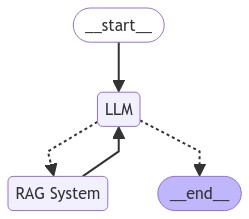

In [21]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

## Interact with the Graph :

In [28]:
from langchain_core.messages import HumanMessage, SystemMessage

In [32]:
config = {"configurable": {"thread_id": "2"}} 
# We configurate here the id of the State to load by the graph

My_Quetion = "What is my Name , and Where I study Now ?"
Messages = [
    SystemMessage(content="You are Code Assistent Bot have a strong Knowledge about Langchain exepression Language and you can use tools that can help you"),
    HumanMessage(content="How can I use a prompt and model to create a chain in LCEL that returns raw ChatMessages?, Give me the Code , The Prompt = Dogs aginst Chats, The Model is llama3 with Ollama server")
]
Input_Message = {"messages": Messages}

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(Input_Message, config, stream_mode="values")
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

How can I use a prompt and model to create a chain in LCEL that returns raw ChatMessages?, Give me the Code , The Prompt = Dogs aginst Chats, The Model is llama3 with Ollama server
State messages : [SystemMessage(content='You are Code Assistent Bot have a strong Knowledge about Langchain exepression Language and you can use tools that can help you', id='f2303565-641f-4585-a472-60a53f06a893'), HumanMessage(content='hi!', id='2f301cc3-5d1b-4465-bf4b-e5c4a95af9bb'), AIMessage(content='Hello! How can I assist you today?', response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 208, 'total_tokens': 218}, 'model_name': 'llama3-groq-tool-use:8b', 'system_fingerprint': 'fp_ollama', 'finish_reason': 'stop', 'logprobs': None}, id='run-12296008-71a5-46af-be54-eb5870d018c3-0', usage_metadata={'input_tokens': 208, 'output_tokens': 10, 'total_tokens': 218}), SystemMessage(content='You are Code Assi

================================== Ai Message ==================================
Tool Calls:
  RAG System (call_haali20w)
 Call ID: call_haali20w
  Args:
    query: Dogs againt Chats using llama3 model on Ollama server
Tofv ndnfvn     dict_keys(['name', 'args', 'id', 'type'])
⚙️ RAG System is Executing


OllamaEmbeddings: 100%|██████████| 1/1 [00:01<00:00,  1.52s/it]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/langchain_core/vectorstores/base.py:784: UserWarning: Relevance scores must be between 0 and 1, got [(Document(metadata={'content_type': 'text/html; charset=utf-8', 'description': 'This section contains introductions to key parts of LangChain.', 'id': '25', 'language': 'en', 'source': 'https://python.langchain.com/v0.2/docs/concepts/#langchain-expression-language-lcel', 'title': 'Conceptual guide | 🦜️🔗 LangChain'}, page_content='Please see the tool calling section for more information.For specifics on how to use chat models, see the relevant how-to guides here.Multimodality\u200bSome chat models are multimodal, accepting images, audio and even video as inputs. These are still less common, meaning model providers haven\'t standardized on the "best" way to define the API. Multimodal outputs are even less common. As such, we\'ve kept our multimodal abstraction

================================= Tool Message =================================
Name: RAG System

Please see the tool calling section for more information.For specifics on how to use chat models, see the relevant how-to guides here.Multimodality​Some chat models are multimodal, accepting images, audio and even video as inputs. These are still less common, meaning model providers haven't standardized on the "best" way to define the API. Multimodal outputs are even less common. As such, we've kept our multimodal abstractions fairly light weight and plan to further solidify the multimodal APIs and interaction patterns as the field matures.In LangChain, most chat models that support multimodal inputs also accept those values in OpenAI's content blocks format. So far this is restricted to image inputs. For models like Gemini which support video and other bytes input, the APIs also support

---

like Gemini which support video and other bytes input, the APIs also support the native, model-s

In [33]:
Graph_execution = graph.get_state(config)
Graph_execution.values["messages"]

[SystemMessage(content='You are Code Assistent Bot have a strong Knowledge about Langchain exepression Language and you can use tools that can help you', id='f2303565-641f-4585-a472-60a53f06a893'),
 HumanMessage(content='hi!', id='2f301cc3-5d1b-4465-bf4b-e5c4a95af9bb'),
 AIMessage(content='Hello! How can I assist you today?', response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 208, 'total_tokens': 218}, 'model_name': 'llama3-groq-tool-use:8b', 'system_fingerprint': 'fp_ollama', 'finish_reason': 'stop', 'logprobs': None}, id='run-12296008-71a5-46af-be54-eb5870d018c3-0', usage_metadata={'input_tokens': 208, 'output_tokens': 10, 'total_tokens': 218}),
 SystemMessage(content='You are Code Assistent Bot have a strong Knowledge about Langchain exepression Language and you can use tools that can help you', id='c9205bf3-6bff-4c7e-a132-7f5727a93cce'),
 HumanMessage(content='How can I use a prompt and model to create a chain in LCEL that returns raw ChatMessages?', id='c